In [1]:
#import libraries

import pandas as pd 
import matplotlib.pyplot as plt 
import lightgbm as lgb 
#import catboost
#from keras.layers import Dense, Dropout
#from keras.models import Sequential
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GroupKFold, StratifiedKFold
import warnings
import multiprocessing
import datetime

warnings.simplefilter('ignore')


In [2]:
#global variables
CSV = False
data_dir = '~/kj_ml/datasets/kaggle/ieee-fraud-detection'


In [4]:
#data load



def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

if CSV:
	#files to load
	files = [data_dir+'/train_transaction.csv',data_dir+'/test_transaction.csv',data_dir+'/train_identity.csv',data_dir+'/test_identity.csv']

	#function to load the data with reduced memory
	def load_data(file):
	    return reduce_mem_usage(pd.read_csv(file))

	with multiprocessing.Pool() as pool:
		train_transaction, test_transaction, train_identity,test_identity = pool.map(load_data, files)

	
else:
	train_transaction = pd.read_pickle(data_dir+'/train_transaction_zip.pkl',compression='zip')
	test_transaction =  pd.read_pickle(data_dir+'/test_transaction_zip.pkl',compression='zip')
	train_identity =    pd.read_pickle(data_dir+'/train_identity_zip.pkl',compression='zip')
	test_identity =     pd.read_pickle(data_dir+'/test_identity_zip.pkl',compression='zip')





In [5]:
#data preprocessing

#merging
train_data = train_transaction.merge(train_identity,on='TransactionID',how = 'left',left_index=True,right_index=True)
test_data = test_transaction.merge(test_identity,on='TransactionID',how='left',left_index=True,right_index=True)
#train_data = train_transaction
#test_data = test_transaction


In [6]:
del train_transaction,test_transaction,train_identity,test_identity

In [7]:
test_data.head()

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,3663549,18403224,31.953125,W,10409,111.0,150.0,visa,226.0,debit,...,chrome 67.0 for android,NaN,NaN,NaN,F,F,T,F,mobile,MYA-L13 Build/HUAWEIMYA-L13
1,3663550,18403263,49.000000,W,4272,111.0,150.0,visa,226.0,debit,...,chrome 67.0 for android,24.0,1280x720,match_status:2,T,F,T,T,mobile,LGLS676 Build/MXB48T
2,3663551,18403310,171.000000,W,4476,574.0,150.0,visa,226.0,debit,...,ie 11.0 for tablet,NaN,NaN,NaN,F,T,T,F,desktop,Trident/7.0
3,3663552,18403310,285.000000,W,10989,360.0,150.0,visa,166.0,debit,...,chrome 67.0 for android,NaN,NaN,NaN,F,F,T,F,mobile,MYA-L13 Build/HUAWEIMYA-L13
4,3663553,18403317,67.937500,W,18018,452.0,150.0,mastercard,117.0,debit,...,chrome 67.0 for android,NaN,NaN,NaN,F,F,T,F,mobile,SM-G9650 Build/R16NW


In [42]:
#handling addr1 and addr2
#dropping addr2 because it is skewed and filling addr1 with max value plus one
train_data['addr1'] = train_data['addr1'].fillna(max(train_data['addr1'])+1.0)

In [ ]:
drop_columns = ['dist1','dist2','id_24', 'id_25', 'id_07', 'id_08', 'id_21', 'id_26', 'id_22', 'id_23',
       'id_27', 'id_18','addr2','R_emaildomain','D1','D2','D3','D4','D5','D6','D7','D8','D9','D10','D11',
                'D12','D13','D14','D15','TransactionID']

In [43]:
#handling dist1 and dist2
#dropping dist1 and dist2 because of large number of nan values
#train_data['dist2'].value_counts(dropna=False)

540.0    65712
299.0    46335
325.0    42751
204.0    42020
264.0    39870
         ...  
316.0        1
128.0        1
120.0        1
313.0        1
340.0        1
Name: addr1, Length: 332, dtype: int64

In [60]:
#handling P_emaildomain
train_data['P_emaildomain'].value_counts(dropna=False)

google       229410
yahoo        105305
others        95484
noInf         94456
microsoft     59182
apple          6703
Name: P_emaildomain, dtype: int64

P_emaildomain is reduced to lesser categories by combining different ids and assigning 'others' to rest. 'noInf' is used to fill null values.

In [59]:
train_data.loc[train_data['P_emaildomain'].isin(['gmail','gmail.com','mail.com']),'P_emaildomain'] = 'google'
train_data.loc[train_data['P_emaildomain'].isin(['yahoo.co.uk','yahoo.de','yahoo.co.jp','yahoo.es','yahoo.fr',
                                             'yahoo.com.mx','ymail.com','yahoo.com']),'P_emaildomain'] = 'yahoo'
train_data.loc[train_data['P_emaildomain'].isin(['hotmail.com','outlook.com','msn.com', 'live.com.mx', 
                                         'hotmail.es','hotmail.co.uk', 'hotmail.de',
                                         'outlook.es', 'live.com', 'live.fr']),'P_emaildomain'] = 'microsoft'
train_data.loc[train_data['P_emaildomain'].isin(['icloud.com','mac.com']),'P_emaildomain'] = 'apple'
train_data['P_emaildomain'].fillna('noInf',inplace = True)
train_data.loc[~train_data['P_emaildomain'].isin(['google','yahoo','microsoft','apple','noInf']),'P_emaildomain'] = 'others'

In [69]:
#handling R_emaildomain
train_data.groupby('isFraud')['R_emaildomain'].value_counts(dropna=False)
#dropping R_emaildomain as it is not seems adding any value. Having 76% nan values

isFraud  R_emaildomain 
0        NaN               443813
         gmail.com          50336
         hotmail.com        25369
         anonymous.com      19931
         yahoo.com          11232
                            ...  
1        aim.com                1
         msn.com                1
         prodigy.net.mx         1
         sbcglobal.net          1
         suddenlink.net         1
Name: R_emaildomain, Length: 94, dtype: int64

In [70]:
test_data['R_emaildomain'].value_counts(dropna=False).iloc[0]/len(test_data)

0.7318484046489873

In [71]:
#handling C1-C14
# no changes for now
for i in range(1,15):
    print(train_data['C'+str(i)].value_counts(dropna=False))

1.0       316791
2.0       105071
3.0        51315
4.0        28845
5.0        17922
           ...  
922.0          1
1477.0         1
1478.0         1
3682.0         1
3522.0         1
Name: C1, Length: 1495, dtype: int64
1.0       316261
2.0       103948
3.0        51770
4.0        28251
5.0        16971
           ...  
1319.0         1
1552.0         1
1318.0         1
1316.0         1
1056.0         1
Name: C2, Length: 1167, dtype: int64
0.0     588111
1.0       2137
2.0        180
3.0         58
4.0          7
16.0         6
9.0          5
11.0         5
5.0          3
13.0         3
14.0         3
10.0         2
8.0          2
12.0         2
15.0         2
7.0          2
17.0         2
6.0          1
19.0         1
20.0         1
21.0         1
22.0         1
23.0         1
24.0         1
25.0         1
26.0         1
18.0         1
Name: C3, dtype: int64
0.0       451883
1.0       111817
2.0        12994
3.0         4949
4.0         1902
           ...  
288.0          1
260.0

In [72]:
#handling D1-D15
#dropping all D1-D15 columns for now as there are a lot of nan values.
for i in range(1,16):
    print(train_data['D'+str(i)].value_counts(dropna=False))

0.0      280130
1.0        8634
2.0        4969
3.0        3954
4.0        3570
          ...  
621.0       109
619.0       107
638.0        79
639.0        42
640.0        14
Name: D1, Length: 642, dtype: int64
NaN      280797
0.0       15124
1.0        6654
2.0        4454
3.0        3677
          ...  
618.0       100
619.0        97
638.0        42
639.0        36
640.0        14
Name: D2, Length: 642, dtype: int64
NaN      262878
0.0       73094
1.0       21258
2.0       13789
7.0       13320
          ...  
630.0         1
634.0         1
638.0         1
639.0         1
590.0         1
Name: D3, Length: 650, dtype: int64
NaN      168922
0.0      166571
1.0        5315
2.0        3385
3.0        2572
          ...  
765.0         1
772.0         1
714.0         1
761.0         1
833.0         1
Name: D4, Length: 809, dtype: int64
NaN      309841
0.0       65377
1.0       15282
2.0       10244
7.0        9734
          ...  
801.0         1
671.0         1
669.0         1
643.0   

In [76]:
#handling M1-M9
#filling nan values with 'Miss'. Rest is same for now
for i in range(1,10):
    
    train_data['M'+str(i)].fillna('Miss',inplace=True)
    print(train_data.groupby('isFraud')['M'+str(i)].value_counts(dropna=False))

isFraud  M1  
0        T       313073
         Miss    256779
         F           25
1        Miss     14321
         T         6342
Name: M1, dtype: int64
isFraud  M2  
0        T       280310
         Miss    256779
         F        32788
1        Miss     14321
         T         5158
         F         1184
Name: M2, dtype: int64
isFraud  M3  
0        Miss    256779
         T       247438
         F        65660
1        Miss     14321
         T         4293
         F         2049
Name: M3, dtype: int64
isFraud  M4  
0        Miss    276217
         M0      189207
         M2       53056
         M1       51397
1        M0        7198
         M2        6809
         Miss      5227
         M1        1429
Name: M4, dtype: int64
isFraud  M5  
0        Miss    337388
         F       128977
         T       103512
1        Miss     13094
         T         4055
         F         3514
Name: M5, dtype: int64
isFraud  M6  
0        F       222459
         T       190029
         

In [78]:
#handling card1-card6
#filling nan values with max frequency value. Rest is same for now.
for i in range(1,7):
    train_data['card'+str(i)].fillna(train_data['card'+str(i)].value_counts().index[0],inplace=True)
    print(train_data['card'+str(i)].value_counts(dropna=False))

7919     14932
9500     14162
15885    10361
17188    10344
15066     7945
         ...  
12390        1
10341        1
10006        1
15743        1
17105        1
Name: card1, Length: 13553, dtype: int64
321.0    57868
111.0    45191
555.0    41995
490.0    38145
583.0    21803
         ...  
447.0       39
153.0       38
557.0       37
473.0       18
582.0       14
Name: card2, Length: 500, dtype: int64
150.0    522852
185.0     56346
106.0      1571
146.0      1252
144.0      1252
          ...  
228.0         1
139.0         1
114.0         1
164.0         1
221.0         1
Name: card3, Length: 114, dtype: int64
visa                386344
mastercard          189217
american express      8328
discover              6651
Name: card4, dtype: int64
226.0    300805
224.0     81513
166.0     57140
102.0     29105
117.0     25941
          ...  
175.0         1
173.0         1
167.0         1
234.0         1
204.0         1
Name: card5, Length: 119, dtype: int64
debit              441509


In [80]:
#handling ProductCD
#Keeping it same 
train_data['ProductCD'].value_counts(dropna=False)

W    439670
C     68519
R     37699
H     33024
S     11628
Name: ProductCD, dtype: int64

In [96]:
#handling TransactionAmt
#No changes for now, try binning. Put values in categories
train_data['TransactionAmt'].value_counts(dropna=False)
max(train_data['TransactionAmt'])
min(train_data['TransactionAmt'])
sum(train_data['TransactionAmt'] > 1000)

7265

In [16]:
#dropping columns above 90% null values

null_features = ((train_data.isnull().sum()/len(train_data)).sort_values(ascending = False) > .90).loc[((train_data.isnull().sum()/len(train_data)).sort_values(ascending = False) > .90)].index
print(null_features)

Index(['id_24', 'id_25', 'id_07', 'id_08', 'id_21', 'id_26', 'id_22', 'id_23',
       'id_27', 'dist2', 'D7', 'id_18'],
      dtype='object')


In [7]:

train_data.drop(null_features,axis = 1,inplace = True)
test_data.drop(null_features,axis=1,inplace=True)


#categorical features
cat_features = train_data.select_dtypes(include = 'object').columns
print('Categorical Features:',cat_features)

'''#non categorical featues
non_cat_features = list(train_data)
for c in cat_features:
	non_cat_features.remove(c)

print(non_cat_features)'''

#handling null values
train_data[cat_features].fillna('others',inplace=True)
train_data.fillna(0,inplace=True)
test_data[cat_features].fillna('others',inplace=True)
test_data.fillna(0,inplace=True)


#getting label
y_train = train_data['isFraud']
train_data = train_data.drop('isFraud',axis = 1)

##Encoding
#Label Encoding
for c in cat_features:
	train_data[c] = train_data[c].astype(str)
	test_data[c] = test_data[c].astype(str)

	le = LabelEncoder()
	le.fit(list(train_data[c])+list(test_data[c]))
	train_data[c] = le.transform(train_data[c])
	test_data[c] = le.transform(test_data[c])
	train_data[c] = train_data[c].astype('category')
	test_data[c] = test_data[c].astype('category')


Categorical Features: Index(['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain', 'M1',
       'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'id_12', 'id_15',
       'id_16', 'id_28', 'id_29', 'id_30', 'id_31', 'id_33', 'id_34', 'id_35',
       'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo'],
      dtype='object')


###Feature engineering and feature selection


In [39]:
train_data['TransactionAmt']

31940.0

In [8]:
#handling 'TransactionDT' using it as timedelta 
START_DATE = datetime.datetime.strptime('2017-11-30', '%Y-%m-%d')
train_data['DT'] = train_data['TransactionDT'].apply(lambda x: (START_DATE + datetime.timedelta(seconds = x)))
train_data['DT_M'] = (train_data['DT'].dt.year-2017)*12 + train_data['DT'].dt.month



In [9]:
train_data.drop('DT',axis = 1, inplace=True)

In [10]:
train_data['DT_M']

0         12
1         12
2         12
3         12
4         12
          ..
590535    17
590536    17
590537    17
590538    17
590539    17
Name: DT_M, Length: 590540, dtype: int64

In [20]:
#model train and validation

params = {
                'objective':'binary',
                'boosting_type':'gbdt',
                'metric':'auc',
                'n_jobs':-1,
                'learning_rate':0.01,
                'num_leaves': 2**8,
                'max_depth':-1,
                'tree_learner':'serial',
                'colsample_bytree': 0.85,
                'subsample_freq':1,
                'subsample':0.85,
                'n_estimators':2**9,
                'max_bin':255,
                'verbose':-1,
                'seed': 42,
                'early_stopping_rounds':1,
                'reg_alpha':0.3,
                'num_threads': 6
                
            } 

kfold = GroupKFold(n_splits = 6)
splits = kfold.split(train_data,y_train,groups=train_data['DT_M'])

for fold,(tx,vx) in enumerate(splits):
	x_t,y_t = train_data.iloc[tx],y_train.iloc[tx]
	x_v,y_v = train_data.iloc[vx],y_train.iloc[vx]

	lgb_train = lgb.Dataset(x_t,label=y_t)
	lgb_val = lgb.Dataset(x_v,label=y_v)

	model = lgb.train(params,lgb_train,num_boost_round=10,valid_sets=[lgb_train,lgb_val],verbose_eval=100)


Training until validation scores don't improve for 1 rounds.
Early stopping, best iteration is:
[7]	training's auc: 0.89166	valid_1's auc: 0.84523
Training until validation scores don't improve for 1 rounds.
Early stopping, best iteration is:
[32]	training's auc: 0.905813	valid_1's auc: 0.88041
Training until validation scores don't improve for 1 rounds.
Early stopping, best iteration is:
[30]	training's auc: 0.903892	valid_1's auc: 0.880983
Training until validation scores don't improve for 1 rounds.
Early stopping, best iteration is:
[6]	training's auc: 0.88432	valid_1's auc: 0.863161
Training until validation scores don't improve for 1 rounds.
Early stopping, best iteration is:
[11]	training's auc: 0.889478	valid_1's auc: 0.881505
Training until validation scores don't improve for 1 rounds.
Early stopping, best iteration is:
[12]	training's auc: 0.891433	valid_1's auc: 0.868079


In [24]:
feature_imp = pd.DataFrame({'Column':list(train_data),'importance':model.feature_importance()})

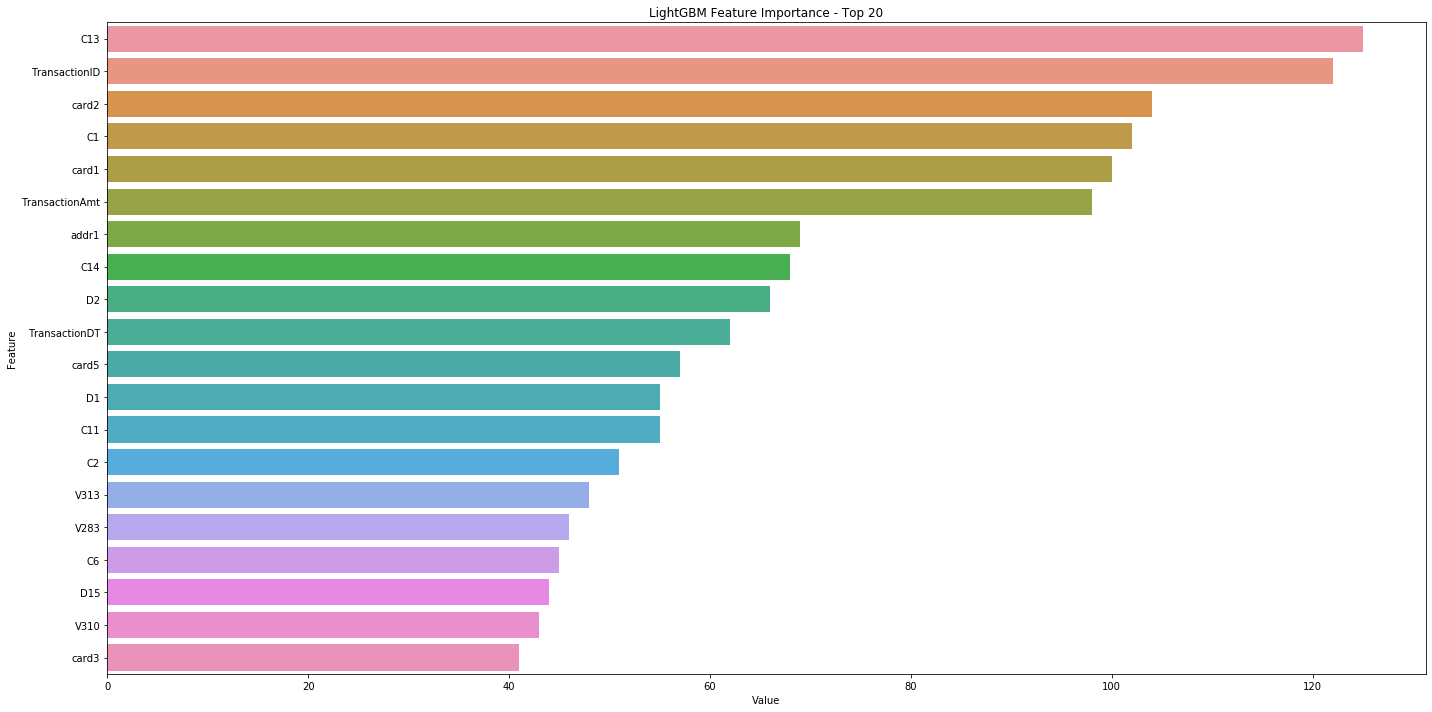

<Figure size 432x288 with 0 Axes>

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

feature_imp = pd.DataFrame(sorted(zip(model.feature_importance(),train_data.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[:20])
plt.title('LightGBM Feature Importance - Top 20')
plt.tight_layout()
plt.show()
plt.savefig('lgbm_importances.png')
